In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
import os
import networkx as nx
import emcee
import corner
from IPython.display import Image
import imp

sn.set_context('talk')

# Import model
nope_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\Python\rid\notebooks\nope.py')
nope = imp.load_source('nope', nope_path)

# Calibrating NOPE

The [previous notebook]() extracted all the observed loads for TOTN and TOTP, plus annual average flow, from the RESA2 database from 1990 to 2016. It also generated input files for the NOPE model for this entire period. These datasets can be used to calibrate and evaluate the new model.

## 1. Calibration and evaluation datasets

Exploration of the observed data suggests there is little temporal autocorrelation in the time series of annual loads (see the example plot below for Glomma). This means it is reasonable, at least initially, to treat each year at each location independently. I will therefore divide the observed dataset into two parts at random: the first part will be used to train the model, the second to evaluate its predictive performance.

**Note:** I have explored temporal autocorrelation, but not spatial autocorrelation. The latter is more complex, but as the 155 RID sites are fairly well distributed across the whole of Norway, I think it's OK to ignore this for now.

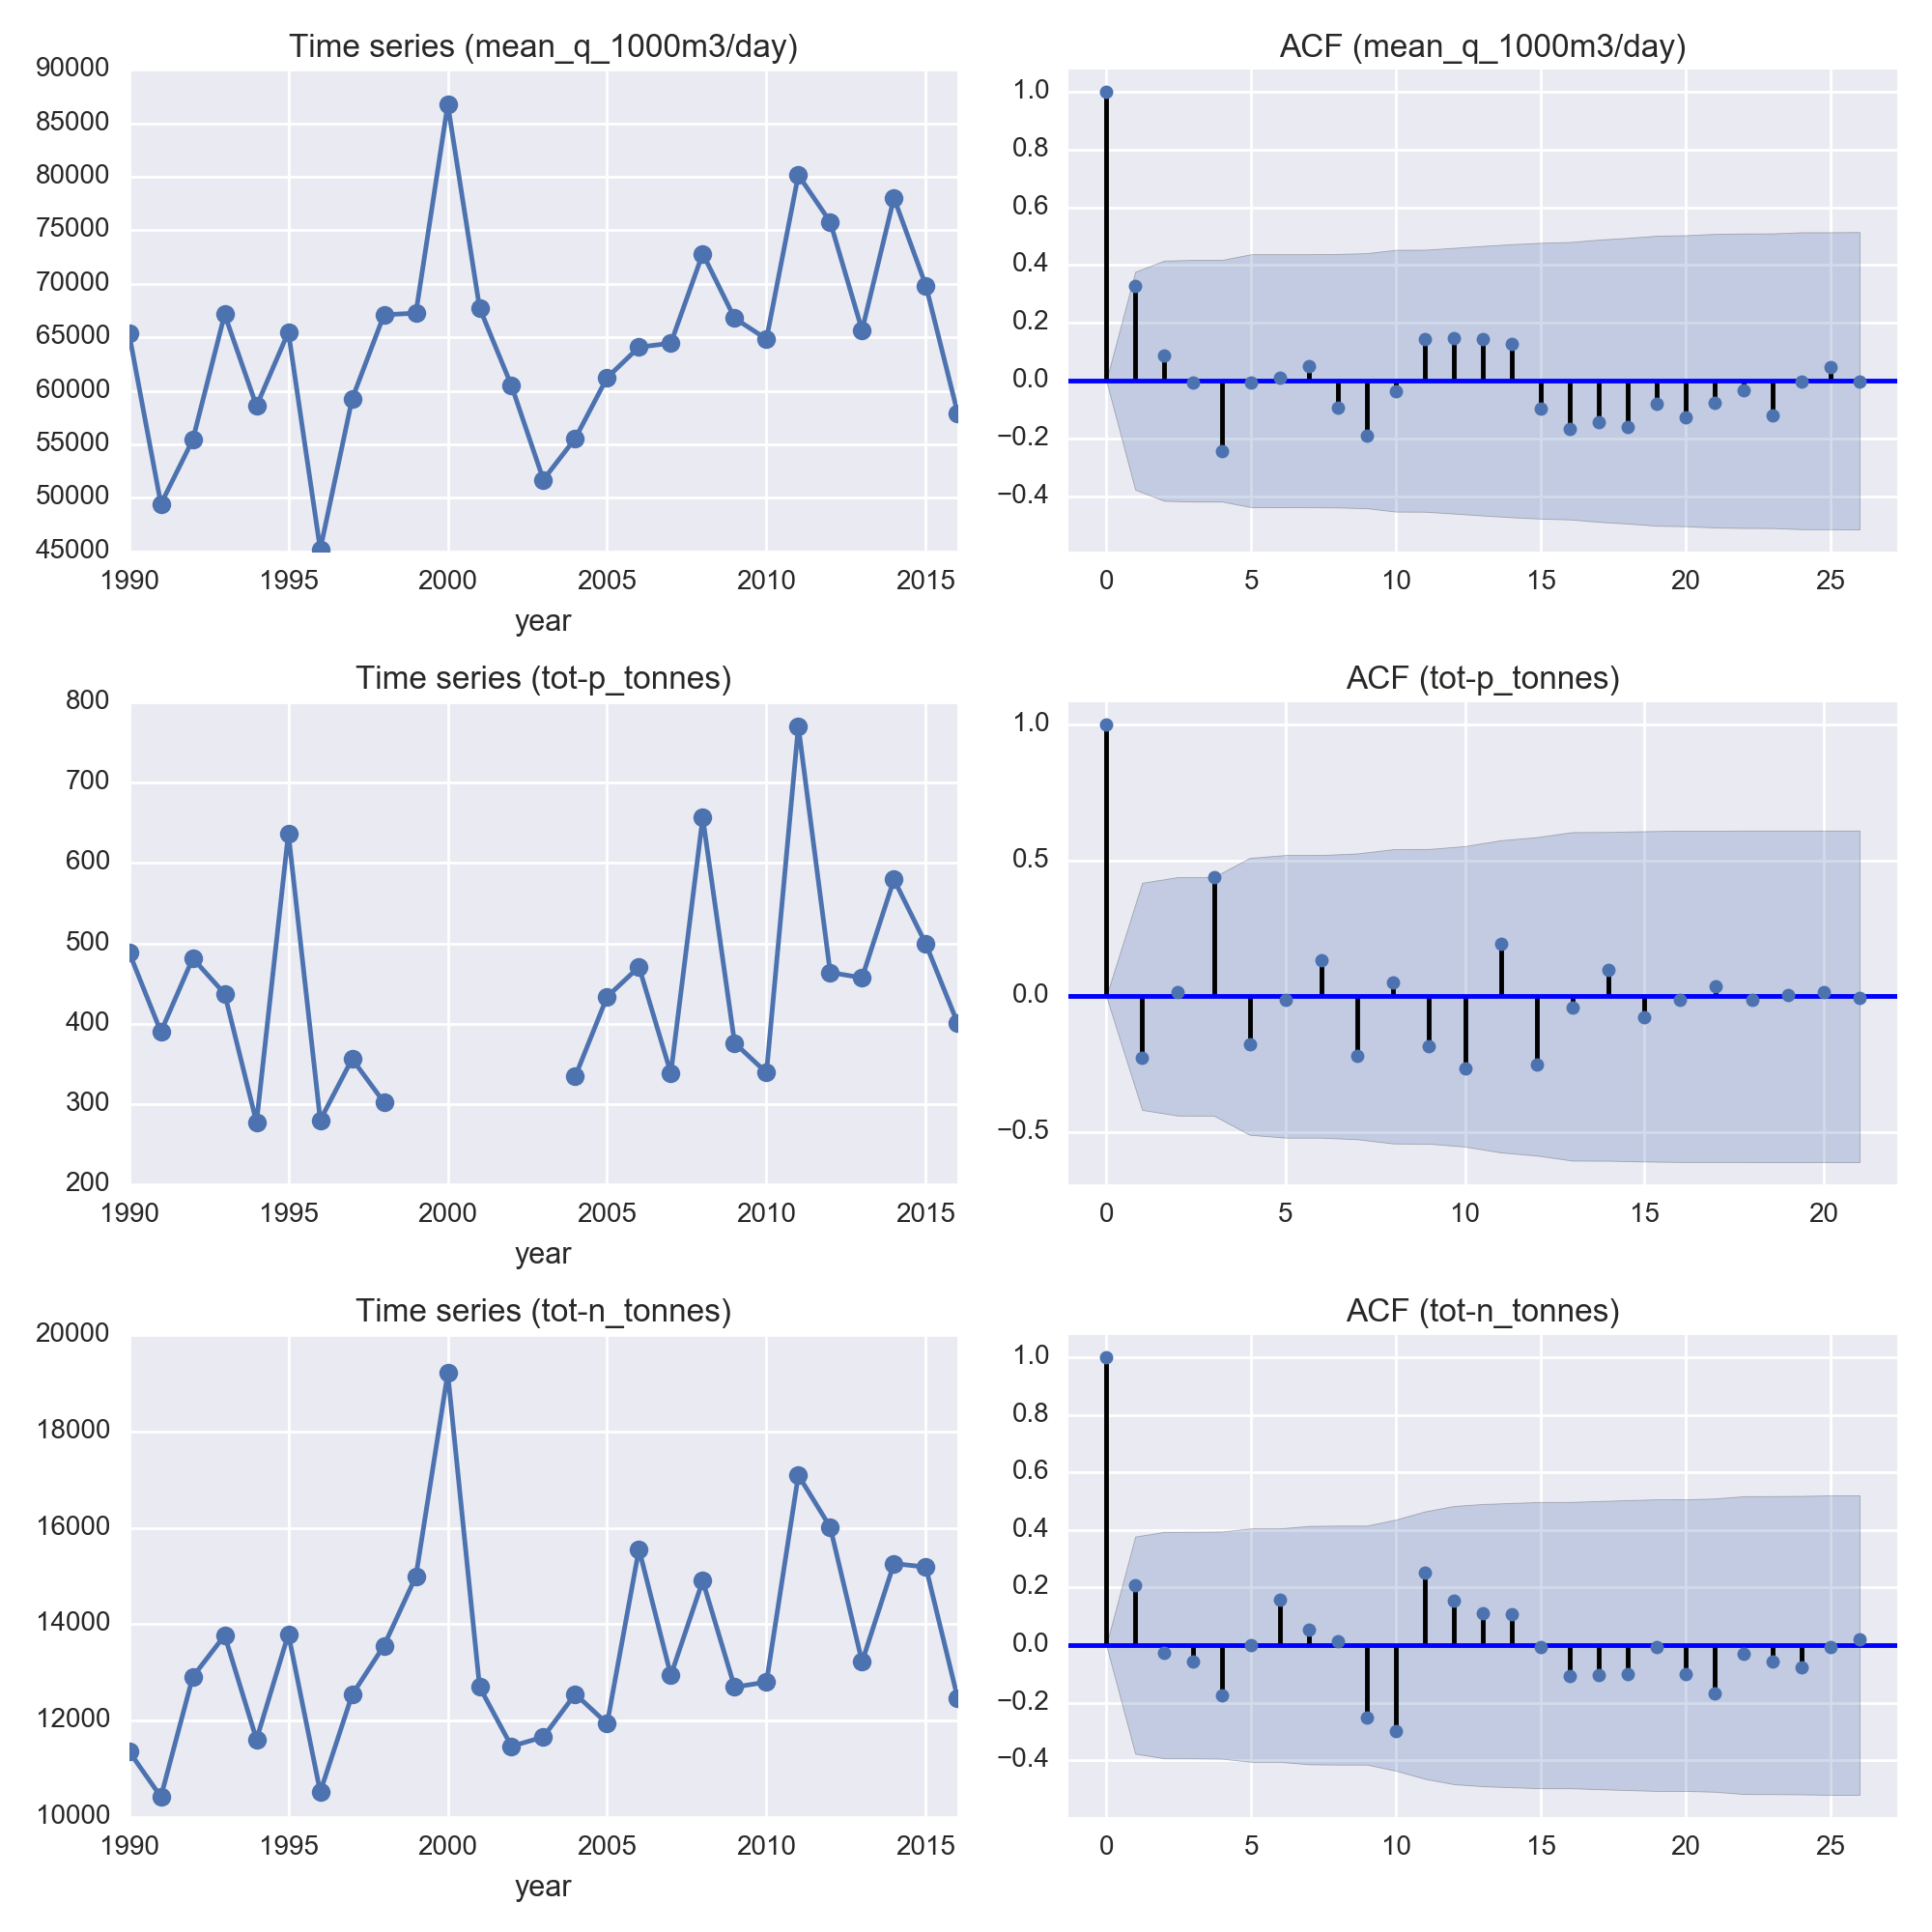

In [2]:
# Show Glomma
png_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\NOPE_RID_Calibration_Data\Autocor_Plots\29617.png')
Image(png_path)

The [previous notebook]() showed there are 1777 years where we have flow, TOTN and TOTP data. This seems like a reasonable calibration dataset to begin with. There is a choice to be made initially between (i) calibrating N and P simultaneously and (ii) calibrating each variable separately. Although it will take longer, the simplest approach is to calibrate each variable separately, so this is where I'll begin. 

**Note:** The justification here is that the size of the parameter space increases exponentially with the number of parameters, whereas the amount of data available increases linearly. In other words, for this application, we have 5 model parameters and 1777 observed data points per chemical variable (see below for a description of the model parameters), so if I choose to calibrate N and P separately I need to consider two 5-dimensional parameter spaces, each with 1777 observed data points. If, on the other hand, I attempt to calibrate both parameters simultaneously, I will have a 10-dimensional parameter space with $2 \times 1777 = 3554$ observed data points. This more computationally challenging, because the 10-D parameter space is much more than twice the size of the the 5-D parameter space.

In reality, the two approaches as outlined above are not actually directly comparable: calibrating separately implicitly assumes no parameter interactions between chemical variables i.e. the covariance between N and P parameters is always 0. For a straightforward implementation of the simultaneous calibration method, on the other hand, it is possible for the N and P parameters to co-vary. If we introduce an additional constraint so that the covariance between parameters for different chemical species is always 0, the 10-D parameter space will be exactly twice the size of the 5-D parameter space, and the simultaneous option will therefore be more efficient (and should give the same answer). However, it's not immediately clear to me how to impose this constraint, so for simplicity I'll stick with separate calibrations to begin with.

I will initially try a 60-40 train-test split i.e. use 60% of the data for calibration and keep 40% back for evaluation.

In [3]:
# Read obs data
obs_df, cal_df, val_df = nope.read_obs_data(0.6)

cal_df.head()

station_id  year  mean_q_1000m3/day  obs_tot-p_tonnes  obs_tot-n_tonnes  \
1152       30114  1994         272.628988          2.288720         41.296476   
1687       30069  1991        2132.859282          3.113975         50.602086   
302        29822  1996        5783.393434         11.641971        332.325353   
108        29614  2016       13000.913822         14.647246       1030.460000   
1591       30022  1992         199.167785          1.530804        172.033166   

     nve_vassdrag_nr rid_group  
1152         122.2A2   rid_108  
1687           167.A   rid_108  
302           109.A0    rid_36  
108          021.A11    rid_11  
1591         008.A11   rid_108

In [4]:
print 'Calibration years:', len(cal_df)
print 'Validation years: ', len(val_df)
print 'Total:            ', len(obs_df)

Calibration years: 1066
Validation years:  711
Total:             1777


## 2. Model structure and parameterisation

I would like to modify the new model's structure to give it some additional flexibility. For each catchment, the basic model equation will now look like this:

 $$O_i^X = \beta_r^X(1 - r_i^X) (\beta_p^X P_i^X + \beta_d^X D_i^X + I_i^X)$$
 
where $O_i^X$ is the amount of nutrient $X$ flowing out of catchment $i$; $r_i^X$ is the retention factor for catchment $i$; $P_i^X$ and $D_i^X$ are, respectively, the "internal loads" of point- and diffuse-source pollutants added from within catchment $i$; and $I_i^X$ is the input of nutrients received from any upstream catchments. $\beta_p$ and $\beta_d$ are calibrating parameters for the point- and diffuse-source components, respectively, encapsulating the idea that the input data may consistently under- or over-estimate actual nutrient inputs. $\beta_r^X$ is a third calibrating parameter that modifies the transmission ($= 1 - r_i^X$) factors used by TEOTIL.

The retention factor, $r_i^X$, is estimated in a similar way to TEOTIL:

$$r_i^X = \frac{\beta_1^X}{1 + \sqrt{\frac{Q_i}{V_i}}} + \beta_2^X$$

where $\beta_1^X$ and $\beta_2^X$ are calibration parameters; $Q_i$ is the long-term mean annual discharge (in $m^3$) for catchment $i$; and $V_i$ is the total volume of the lakes in catchment $i$ (also in $m^3$). The ratio $\frac{Q_i}{V_i}$ is therefore a rough approximation for the rate at which the lakes are "flushed through": lakes that are replensihed more rapidly are assumed to retain fewer nutrients.

TEOTIL originally assumed that $\beta_1^P = 1$ and $\beta_1^N = 0.2$. $\beta_2^P$ is always assumed to be 0, while the value for $\beta_2^N$ depends on the trophic status of waterbodies in the catchment. **Note:** there is a mistake in section 2.4 of the TEOTIL report describing these aspects of the model - the correct equation is outlined by John Rune in an e-mail received 01/09/2017 at 15.47.

For the calibration here, I will simply use the same deterministic retention factors estimated for TEOTIL, but incorporating an additional calibration parameter, $\beta_r^X$, to account for possible bias in the estimated factors. The full model equation for each variable is therefore as given above, and involves three calibrating parameters: $\beta_r^X$, $\beta_p^X$ and $\beta_d^X$.

## 3. Model performance

The model code needs modifying to allow for the new parameterisation described in section 2. Additionally, for calibration purposes, a single model run will require simulating loads for the whole of Norway (or at least the 155 monitored sites) for every year from 1990 to 2015. What's more, a full calibration will require thousands of simulations. 

My first attempt at creating a new model achieved run times of around 5 seconds per year, which is a substantial improvement on the ~8 hours previously taken by TEOTIL. However, this implies that each 26-year run will require around 130 seconds, so thousands of runs will still require a lot of computer time. Hopefully some basic optimisation will further reduce runtimes. The most obvious performance tweaks to start with are:

 * **Avoid repeatedly looping over/querying dataframes**. The entire input dataset can be read into memory and converted to a nested dictionary with keys `('regine', year)` and values `{'variable':value}`. This will take a few seconds at the start of the simulation, but afterwards any value for any year can be accessed with two dictionary lookups, which are $O(1)$ and fast. <br><br>
 
 * **Avoid repeatedly re-creating the network**. The catchment network stays the same over time, so it is not necessary to re-build it each year. Instead, the network can be created once and the node properties can be repeatedly updated, which should be faster. <br><br>
 
 * **Only process catchments in the calibration dataset**. It is not necessary to process the whole of Norway - just the catchments upstream of the 155 sites with monitoring data. It may be possible to extract a sub-network for just these sites at the start of the simulation, and then subsequently focus on just these locations.

### 3.1. Read and streamline input data

In [5]:
# Year of interest
st_yr, end_yr = 1990, 2015

# Pars of interest
par_list = ['tot-n', 'tot-p']

# Build input dict
in_data = nope.build_input_dict(st_yr, end_yr, par_list)

### 3.2. Pre-build network for the calibrating catchments

I have added the function `build_calib_network()` to NOPE. This takes as input a single input CSV representing the full catchment network, and a list of the nodes for which calibration data are available. The function first builds the full network, then works out which catchments are upstream of the nodes with observed data and returns a sub-network for just these catchments.

In [6]:
# Get catch IDs with calib data
calib_nds = set(cal_df['nve_vassdrag_nr'].values)

# Build network
in_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\NOPE_Annual_Inputs\nope_input_data_1990.csv')
g, nd_list = nope.build_calib_network(in_path, calib_nds)

### 3.3. Run model in multi-year model

I have also written two further NOPE functions, `run_model_multi_year()` and `update_and_accumulate()`, which make use of the pre-built network and data dictionary created above. `run_model_multi_year()` takes a dictionary of calibrating parameter values, which will eventually be supplied by the MCMC code. If no dictionary is passed, all parameters are assumed to be 1 by default.

The code below sets all the calibrating parameters to 1 (i.e. uses the default values from TEOTIL) and measures the runtime for total-N and total-P for the entire 26 year period from 1990 to 2015.

In [7]:
%%time

# Run model with default params
df = nope.run_model_multi_year(g, nd_list, st_yr, end_yr, in_data, 
                               par_list, calib_nds, cal_pars=None)

Wall time: 4.95 s


In [8]:
df.head()

regine  year     q_m3/s  tot-n_tonnes  tot-p_tonnes
0  015.4B1  1990  15.596292    163.728044      3.560526
1    089.A  1990  35.939460    174.177172      1.124574
2  212.6A0  1990   2.791666     22.425292      0.399631
3  008.A11  1990   3.448189    133.848952      4.180638
4  028.3A0  1990   4.907740    576.977287     16.483150

This is a pretty good result. Although it takes a minute or so at the start of the simulation to build the input data dictionary and the cut-down catchment network, once this has been done I can process 26 years of data in about 5 seconds. This is approximately a 26-fold speed-up compared to my initial attempt, and it's more than 140 000 times faster than TEOTIL. Further optimisations are possible, but 5 seconds per run is a pretty reasonable starting point for effective MCMC.

Before getting into any statistcal details, I would first of all like to check how well the default output matches the observations.

### 3.4. Compare default model output to observations

The code below links the model simulations to the observed data for the 155 RID stations.

In [9]:
# Join results
df = pd.merge(obs_df, df, how='left',
              left_on=['nve_vassdrag_nr', 'year'],
              right_on=['regine', 'year'])

# Convert obs flow to m3/s
df['obs_q_m3/s'] = df['mean_q_1000m3/day']*1000/(24*60*60)
del df['mean_q_1000m3/day']

df.head()

station_id  year  obs_tot-p_tonnes  obs_tot-n_tonnes nve_vassdrag_nr  \
0       29615  1990         39.700336       1235.212106          015.A1   
1       29615  1991         33.353097       1105.169503          015.A1   
2       29615  1992         23.337892       1409.367745          015.A1   
3       29615  1993         52.173714       1586.323638          015.A1   
4       29615  1994         33.284365       1724.631323          015.A1   

  rid_group  regine      q_m3/s  tot-n_tonnes  tot-p_tonnes  obs_q_m3/s  
0    rid_11  015.A1  162.269632   1805.453806     27.549689  117.119821  
1    rid_11  015.A1  121.824784   1555.189987     25.092207   91.260339  
2    rid_11  015.A1  130.243022   1583.410979     24.792755   90.722083  
3    rid_11  015.A1  152.674548   1768.018713     30.710944  114.207464  
4    rid_11  015.A1  173.973088   1909.073868     31.541542  125.269546

In [10]:
# Drop 2016 obs data as can't model this yet
df = df.query('year != 2016')

# Assert no NaN
assert ~pd.isnull(df).all().all()

In [11]:
def plot_mod_obs(df):
    """ Simple plot to asses goodness-of-fit of model results.
    
    Args:
        df: Dataframe of modelled and observed values.
        
    Returns:
        None
    """
    # Plot
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

    # Pairs to plot
    data_pairs = [('Total N (tonnes)', 'obs_tot-n_tonnes', 'tot-n_tonnes'),
                  ('Total P (tonnes)','obs_tot-p_tonnes', 'tot-p_tonnes'),
                  ('Discharge (m3/s)', 'obs_q_m3/s', 'q_m3/s')]

    # Loop over pairs
    for idx, item in enumerate(data_pairs):
        # Plot un-logged
        axes[0, idx].plot(df[item[1]], df[item[2]], 'o', label='')
        axes[0, idx].plot(df[item[1]], df[item[1]], 'k-', label='1:1 line')
        axes[0, idx].set_xlabel('Observed')
        axes[0, idx].set_ylabel('Modelled')
        axes[0, idx].set_title(item[0])
        axes[0, idx].legend(loc='upper left')

        # Plot logged
        axes[1, idx].plot(df[item[1]], df[item[2]], 'o', label='')
        axes[1, idx].plot(df[item[1]], df[item[1]], 'k-', label='1:1 line')
        axes[1, idx].set_xlabel('Observed')
        axes[1, idx].set_ylabel('Modelled')
        axes[1, idx].set_title('log[%s]' % item[0])
        axes[1, idx].legend(loc='upper left')
        axes[1, idx].set_xscale('log')
        axes[1, idx].set_yscale('log')

    plt.tight_layout()
    
    return None

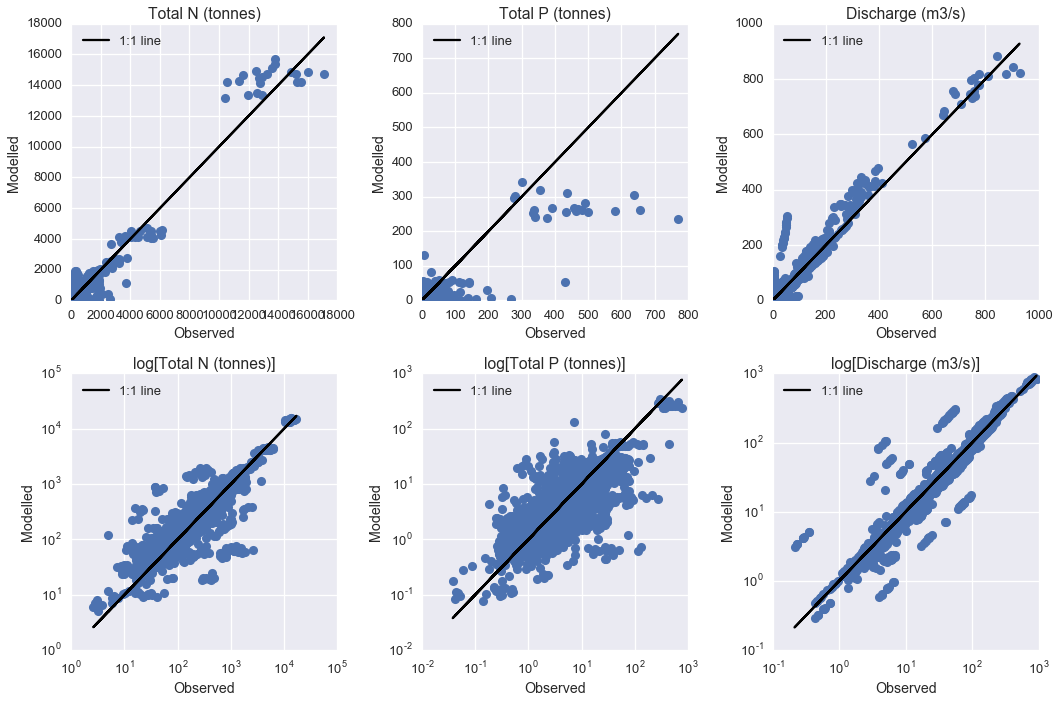

In [13]:
# Plot results
plot_mod_obs(df)

Overall, this default parameterisation works remarkably well. Note the following:

 * Even though the new model has a slightly different structure to TEOTIL (i.e. a different set of equations), the default TEOTIL parameters are pretty good. <br><br>
 
 * For many sites, the model consistently underestimates P loads. This is a known issue with TEOTIL too, and my proposed calibration procedure (as outlined above) is unlikely to address this, because the problem is clearly spatially variable. <br><br>
 
 * There are some catchments where the discahrge is not estimated well. This implies some errors with e.g. catchment areas, most likely in the RESA2 database.

## 4. Bayesian parameter inference

To understand parameter-related uncertainty, we want to estimate a probability distribution for the model parameters, $\theta$, *given the available observations, $D$, and our prior knowledge of the system*. This distribution is written $P(\theta ∣ D)$ and is given by Bayes' equation:

$$P(\theta ∣ D) = \frac{P(D ∣ \theta) P(\theta)}{\int_{\theta} P(D ∣ \theta) P(\theta) d\theta}$$

The integral in the denominator of this equation is just a constant, but it is difficult to evaluate. However, in this application we are focusing on parameter-related uncertainty in a single model (rather than attempting Bayesian comparison of multiple models), so we can ignore this constant and simply write:

$$P(\theta ∣ D) \propto P(D ∣ \theta) P(\theta)$$

In this formulation, $P(\theta)$ is the **prior distribution**, representing what we know about the parameters before we incorporate the observational data, and $P(D ∣ \theta)$ is the **likelihood function**, which describes the probability that the model, when run with a specific set of parameters, will be capable of simulating the observed dataset. $P(\theta ∣ D)$ is the **posterior distribution** and it is the main quantity of interest in this analysis.

### 4.1. Likelihood function

The likelihood function describes the distribution of errors between the model output and the observations. Given the lack of temporal autocorrelation in the annual observations, it seems reasonable to assume, at least initially, that these errors are **independent and identically distributed (i.i.d)**. This assumption can be checked at the end of the analysis and revised if necessary. The most common choice of distribution is the Gaussian, $\mathcal{N}(\mu,\sigma^2)$, but this assigns very low probability to values more than a few standard deviations away from the mean. As a result, Gaussian likelihoods penalise outliers very severely, with the consequence that the calibration algorithm will favour model simulations with low variance. In other words, using a Gaussian likelihood may result in the model simulating roughly constant values close to the mean of the observations. By doing so, the model provides mediocre simulations for all data points which, because of the Gaussian likelihood, often gives better performance (at least, in a statistical sense) than simulating most of the data well, but with a small number of substantial outliers. 

For this application, such characteristics are undesirable: it is quite likely that our datasets omit key pollutant sources in some areas, so a few large outliers might be expected. For the work here, it is therefore better to simulate most of the data well (but allowing a few outliers), than to simulate all of the data points "averagely". One way to achieve this is to use a likelihood function with "heavier tails", such as the t-distribution, $\mathcal{T}(\mu,\sigma^2, \nu)$. The t-distribution is similar to a Gaussian, but with an additional degrees-of-freedom parameter, $\nu$. As $\nu \to \infty$, the t-distribution becomes a Gaussian distribution, whereas values of $\nu$ close to zero give the distribution heavier tails. Because of these heavy tails, the t-distribution penalises outliers less severely than a Gaussian, as illustrated below.

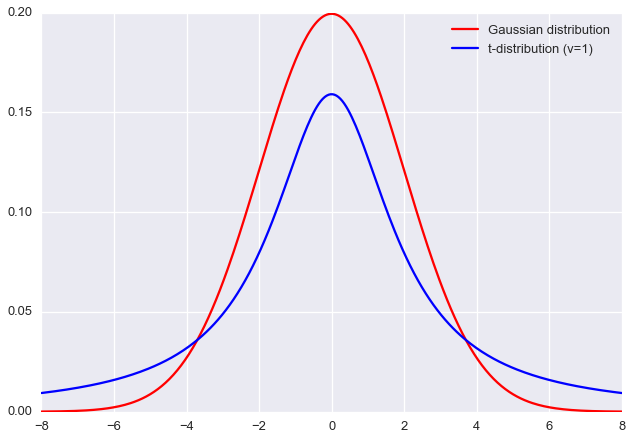

In [12]:
# Example of Gaussian versus Student-T
x_vals = np.linspace(-8, 8, 300)

# PDFs
norm = st.norm.pdf(x_vals, loc=0, scale=2)
stu_t = st.t.pdf(x_vals, df=1, loc=0, scale=2)

# Plot
plt.plot(x_vals, norm, 'r-', label='Gaussian distribution')
plt.plot(x_vals, stu_t, 'b-', label='t-distribution (v=1)')
plt.legend(loc='best')

The equation for a t-distribution is:

$$f(t)={\frac {\Gamma ({\frac {\nu +1}{2}})}{{\sqrt {\nu \pi }} \Gamma ({\frac {\nu }{2}})}}\left(1+{\frac {t^{2}}{\nu }}\right)^{-{\frac {\nu +1}{2}}}$$

where $\Gamma$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function).

### 4.2. Prior distribution

The deterministic part of the model involves three calibrating parameters: $\beta_r^X$, $\beta_p^X$ and $\beta_d^X$. In addition, the stochastic component (the likelihood function) involves an additional three parameters: the mean, $\mu$, variance $\sigma^2$ and the degrees-of-freedom, $\nu$. 

We make the assumption that the model is **unbiased** and therefore $\mu = 0$, but the parameters $\nu$ and $\sigma$ are unknown, and therefore must be included in the calibration procedure.

The priors are selected as follows:

 * $\beta_r^X$ is a correction factor on the transmission coefficient. The overall transmission factor must lie between zero and one, so $\beta_r^X$ must be constrained between zero and one as well. We assume a uniform prior distribution over this interval:

$$\beta_r^X \sim \mathcal{U} (0, 1)$$

 * The parameters $\beta_p^X$ and $\beta_d^X$ represent fractional errors in the point and diffuse inputs, respectively. For example, a calibrated value of $\beta_p^X = 1.2$ would imply that the input data consistently underestimate point-sources of pollution by about 20%. It seems unlikely that the inputs are out by more than a factor of 5, and the most probable value given our current knowledge is roughly one. We therefore assume fairly broad ($\sigma_\beta = 5$), truncated normal distributions for these parameters with means of 1, minimums of 0 and maximums of 5. <br><br>

 * For the t-distribution variance, $\sigma_t^2$ we choose a uniform distribution that is broad relative to the data variance, such as between zero and twice the variance of the observations:

$$\sigma_t^2 \sim \mathcal{U} (0, 2 \sigma_{obs}^2)$$

Finally, for $\nu$ we choose a shifted exponential distribution with minimum 1 and mean 30, which allocates credibility fairly evenly over the range between "nearly normal" and "heavy tailed" ([Kruschke, 2013](http://www.indiana.edu/~kruschke/articles/Kruschke2013JEPG.pdf)).

These choices are illustrated on the plots below.

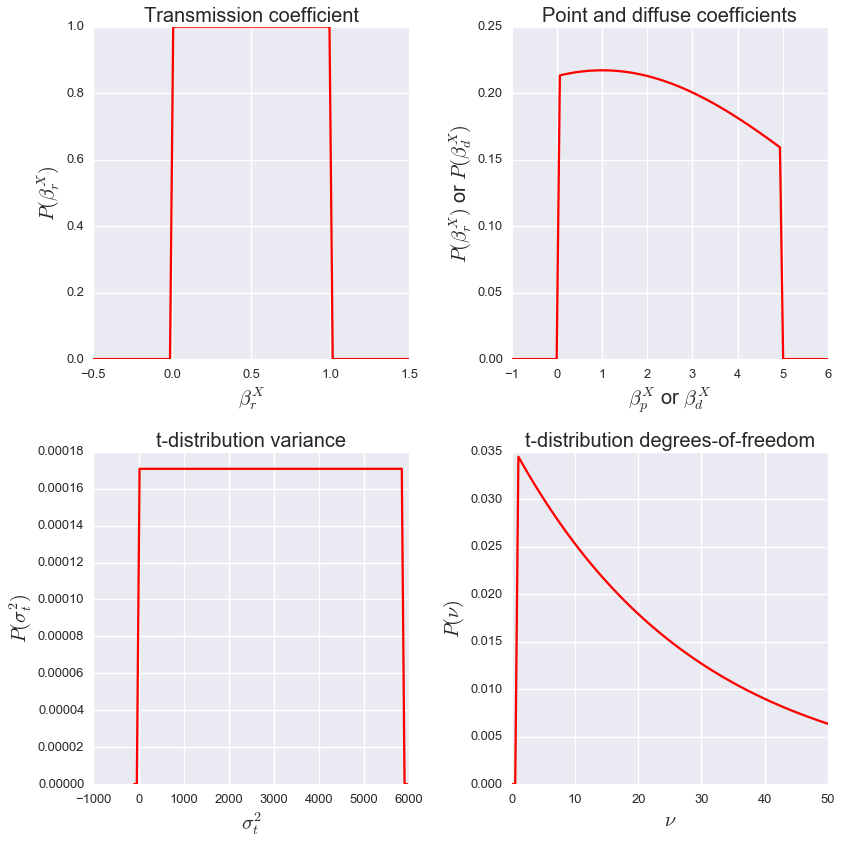

In [13]:
# Setup canvas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

# 1. b_r
x = np.linspace(-0.5, 1.5, 100)
axes[0,0].plot(x, st.uniform.pdf(x), 'r-')
axes[0,0].set_xlabel(r'$\beta_r^X$', fontsize=20)
axes[0,0].set_ylabel(r'$P(\beta_r^X)$', fontsize=20)
axes[0,0].set_title('Transmission coefficient', fontsize=20)

# 2. b_p and b_d
x = np.linspace(-1, 6, 100)

# st.truncnorm is a bit awkward to use
lo, up = 0., 5.
mu, sig = 1., 5.
a, b = (lo - mu)/sig, (up - mu)/sig
pdf = st.truncnorm.pdf(x, a, b, loc=mu, scale=sig)
axes[0,1].plot(x, pdf, 'r-')
axes[0,1].set_xlabel(r'$\beta_p^X$ or $\beta_d^X$', fontsize=20)
axes[0,1].set_ylabel(r'$P(\beta_r^X)$ or $P(\beta_d^X)$', fontsize=20)
axes[0,1].set_title('Point and diffuse coefficients', fontsize=20)

# 3. t-dist sigma
# Get var for P as an example
up = 2*obs_df.var()['obs_tot-p_tonnes']
x = np.linspace(-100, up+100, 100)
axes[1,0].plot(x, st.uniform.pdf(x, loc=0, scale=up), 'r-')
axes[1,0].set_xlabel(r'$\sigma_t^2$', fontsize=20)
axes[1,0].set_ylabel(r'$P(\sigma_t^2)$', fontsize=20)
axes[1,0].set_title('t-distribution variance', fontsize=20)

# 4. t-dist d-o-f
x = np.linspace(0, 50, 100)
axes[1,1].plot(x, st.expon.pdf(x, loc=1, scale=29), 'r-')
axes[1,1].set_xlabel(r'$\nu$', fontsize=20)
axes[1,1].set_ylabel(r'$P(\nu)$', fontsize=20)
axes[1,1].set_title('t-distribution degrees-of-freedom', fontsize=20)

plt.tight_layout()

## 5. Calibration code

For each model run, we need to evaluate the posterior probability:

$$P(\theta ∣ D) \propto \prod_{i=1}^n P(D_i ∣ \theta) \prod_{j=1}^m P(\theta_j)$$

where $n$ is the number of points in the observed dataset and $m$ is the number of calibrating parameters.

In practice, to avoid arithmetic underflow, we typically work with log-probabilities instead:

$$log[P(\theta ∣ D)] \propto \sum_{i=1}^n P(D_i ∣ \theta) + \sum_{j=1}^m P(\theta_j)$$

The required functions are defined in section 5.4. First, though, I'll create a pool of Python processes that I can can use to parallelise the MCMC. These processes will need access to everything that follows, so it's worth creating them now.

### 5.1. Build processor pool for parallel processing

First, from the Jupyter dashboard, start a cluster and run the code below.

In [14]:
from ipyparallel import Client
c = Client()
view = c.load_balanced_view()

### 5.2. Import modules (including NOPE) on all nodes in pool

In [15]:
%%px --local

import imp
import pandas as pd
import numpy as np
import scipy.stats as st
import os
import networkx as nx

# Import model
nope_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\Python\rid\notebooks\nope.py')
nope = imp.load_source('nope', nope_path)

### 5.3. Make data accessible to all nodes in the processing pool

In [16]:
%%px --local

# Year of interest
st_yr, end_yr = 1990, 2015

# Pars of interest
par_list = ['tot-p',]

# Build input dict
in_data = nope.build_input_dict(st_yr, end_yr, par_list)

# Read obs data
obs_df, cal_df, val_df = nope.read_obs_data(0.6)

# Get catch IDs with calib data
calib_nds = set(cal_df['nve_vassdrag_nr'].values)

# Build network
in_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\NOPE_Annual_Inputs\nope_input_data_1990.csv')
g, nd_list = nope.build_calib_network(in_path, calib_nds)

### 5.4. Define log-prior and log-likelihood

In [17]:
%%px --local

def log_prior(par_dict):
    """ Calculate log-prior. The dict should include par values chosen
        by the MCMC algorithm, together with the (previously created)
        function for returning the prior PDF.
    
    Args:
        par_dict: Dict. dict['par_name'] = (par_value, par_dist)
        
    Returns:
        Float. Prior probability of parameters.
    """    
    # Accumulate log prob
    lp = 0
    
    # Loop over dict
    for val, dist in par_dict.values():
        lp += dist.logpdf(val)
    
    return lp

def log_likelihood(par_dict, log_vals=False):
    """ Run model and calculate log-likelihood of data given the
        parameter values.
        
    Args:
        par_dict: Dict. dict['par_name'] = (par_value, par_dist)
        log_vals: Bool. Whether to log-transform data before 
                  evaluating likelihood
        
    Returns:
        Float. Log-probability of data given parameters.        
    """
    # Extract calib pars from par_dict
    cal_pars = {}
    for key in par_dict.keys():
        cal_pars[key] = par_dict[key][0]
        
    # Run model 
    mod_df = nope.run_model_multi_year(g, nd_list, st_yr, end_yr, in_data, 
                                       par_list, calib_nds, cal_pars=cal_pars)

    # Join mod to obs
    df = pd.merge(obs_df, mod_df, how='left',
                  left_on=['nve_vassdrag_nr', 'year'],
                  right_on=['regine', 'year'])    
    
    # Log transform if necessary
    if log_vals:
        # Get val cols
        cols = [i % j for i in ['obs_%s_tonnes', '%s_tonnes'] for j in par_list]
        df = df[cols]
        df = np.log10(df)
    
    # Drop NaN
    df.dropna(how='any', inplace=True)        

    # Calculate log likelihood
    ll = 0

    for par in par_list:
        ll += np.sum(st.t(df=cal_pars['n_t_%s' % par],
                          loc=df['%s_tonnes' % par],
                          scale=cal_pars['s_t_%s' % par]).logpdf(df['obs_%s_tonnes' % par]))
        
#    for par in par_list:
#        ll += np.sum(st.norm(loc=df['%s_tonnes' % par],
#                             scale=cal_pars['s_t_%s' % par]).logpdf(df['obs_%s_tonnes' % par]))
   
    if np.isfinite(ll):
        return ll
    
    else:
        return -np.inf

def log_posterior(cur_pars, par_dict, log_vals=False):
    """ Run model and calculate posterior probability of the parameters 
        given the data.
        
    Args:
        cur_pars: Parameter values to use
        par_dict: Dict. dict['par_name'] = (par_value, par_dist)
        log_vals: Bool. Whether to log-transform data before 
                  evaluating likelihood
        
    Returns:
        Float. Log-probability of parameters given data.        
    """ 
    # Update par_dict with guesses
    for idx, key in enumerate(sorted(par_dict.keys())):
        par_dict[key][0] = cur_pars[idx]
    
    # Get log prior prob
    log_pri = log_prior(par_dict)

    # Evaluate log likelihood if necessary
    if np.isfinite(log_pri):
        log_like = log_likelihood(par_dict, log_vals=log_vals)
        
        # Calculate log posterior
        return log_pri + log_like
    
    else:
        # Log prior is -inf, so log posterior is -inf too
        return -np.inf

def neg_log_posterior(cur_pars, par_dict, log_vals=False):
    """ Negative of log posterior.
    """    
    return -log_posterior(cur_pars, par_dict, log_vals=log_vals)

def find_map(par_dict, log_vals=False, method='BFGS'):
    """ Find max of posterior.
    """
    from scipy import optimize 
    
    # Get init guesses from par_dict
    cur_pars = []
    for key in sorted(par_dict.keys()):
        cur_pars.append(par_dict[key][0])
   
    # Run optimiser
    opt = optimize.minimize(neg_log_posterior, 
                            cur_pars, 
                            args=(par_dict, log_vals),
                            method=method,
                            options={'disp':True})
    param_est = opt.x
    
    # Update par_dict with latest guesses
    for idx, key in enumerate(sorted(par_dict.keys())):
        par_dict[key][0] = param_est[idx]    

    return par_dict

In [18]:
# Define priors as described in notebook text

# Define pars for prior on b_p and b_d
lo, up = 0., 5.
mu, sig = 1., 5.
a, b = (lo - mu)/sig, (up - mu)/sig
st.truncnorm(a, b, loc=mu, scale=sig)

# Define pars for prior on s_t_n and s_t_p
up_p = obs_df.var()['obs_tot-p_tonnes']
up_n = obs_df.var()['obs_tot-n_tonnes']

# Define functions and initial parameter set
# NB: Parameters et must be valid i.e. sigma and nu can't be zero
par_dict = {#'b_r_tot-n':[0.5, st.uniform(loc=0, scale=1)],
            'b_r_tot-p':[0.5, st.uniform(loc=0, scale=1)],
            #'b_p_tot-n':[1., st.truncnorm(a, b, loc=mu, scale=sig)],
            'b_p_tot-p':[1., st.truncnorm(a, b, loc=mu, scale=sig)],
            #'b_d_tot-n':[1., st.truncnorm(a, b, loc=mu, scale=sig)],
            'b_d_tot-p':[1., st.truncnorm(a, b, loc=mu, scale=sig)],
            #'s_t_tot-n':[up_n, st.uniform(loc=0, scale=2*up_n)], 
            's_t_tot-p':[up_p, st.uniform(loc=0, scale=2*up_p)],
            #'n_t_tot-n':[30., st.expon(loc=1, scale=29)], 
            'n_t_tot-p':[30., st.expon(loc=1, scale=29)]}

### 5.5. Find the map

This may not be necessary, but might save some time.

In [19]:
## Begin using all uniform priors for now
#par_dict = {'b_r_tot-n':[0.5, st.uniform(loc=0, scale=1)],
#            'b_r_tot-p':[0.5, st.uniform(loc=0, scale=1)],
#            'b_p_tot-n':[1.5, st.uniform(loc=0, scale=3)],
#            'b_p_tot-p':[1.5, st.uniform(loc=0, scale=3)],
#            'b_d_tot-n':[1.5, st.uniform(loc=0, scale=3)],
#            'b_d_tot-p':[1.5, st.uniform(loc=0, scale=3)],
#            's_t_tot-n':[500., st.uniform(loc=0, scale=1000)], 
#            's_t_tot-p':[500., st.uniform(loc=0, scale=1000)]}
#
## Run optimiser
#par_dict = find_map(par_dict, log_vals=False, method='BFGS')
#
## Print MAP pars
#for key in sorted(par_dict.keys()):
#    print '%s:\t%.2f' % (key, par_dict[key][0])

### 5.6. Run the MCMC

I'm using the affine invariant MCMC ensemble sampler implemented by [emcee](http://dan.iel.fm/emcee/current/). 40 chains with 1500 steps each should be sufficient, with the first 1000 steps in each chain discarded as "burn-in".

The results below are for P.

In [20]:
def run_mcmc(n_dim, n_walk, n_steps, n_burn, par_dict, out_png, 
             out_txt, log_vals=False):
    """ Sample posterior using emcee.
    
            n_dim      Number of parameters being calibrated
            n_walk     Number of walkers/chains (must be even)
            n_steps    Number of steps taken by each walker
            n_burn     Number of steps to discard as "burn-in"
            par_dict:
            out_path:
            log_vals:
        
        Produces plots of the chains.
        
        Returns an array of samples (with the burn-in discarded).
    """
#    # Get start point from par_dict (if this is the dict returned by
#    # find_map(), this will be the MAP)
#    par_opt = []
#    for key in sorted(par_dict.keys()):
#        par_opt.append(par_dict[key][0])
#        
#    # Generate starting locations for the chains by adding a small
#    # amount of Gaussian noise to optimised MAP
#    starting_guesses = [par_opt + 1e-2*np.random.randn(n_dim) 
#                        for i in range(n_walk)]
    
    # Start chains randomly within priors
    starting_guesses = []
    for key in sorted(par_dict.keys()):
        starting_guesses.append(par_dict[key][1].rvs(size=n_walk))
    starting_guesses = zip(*starting_guesses)

    # Prepare to sample. The params are automatically passed to log_posterior
    # as part of n_dim. "args" lists the other params that are also necessary
    sampler = emcee.EnsembleSampler(n_walk, n_dim, log_posterior, pool=view,
                                    args=[par_dict, log_vals])

    # Run sampler
    pos, prob, state = sampler.run_mcmc(starting_guesses, n_steps)

    # Print some stats. based on run properties
    print '\n'
    print 'Average acceptance fraction: ', np.mean(sampler.acceptance_fraction)
    #print 'Autocorrelation time: ', sampler.acor

    # Get results
    # Plot traces, including burn-in
    param_labels = sorted(par_dict.keys())
    fig, axes = plt.subplots(nrows=n_dim, ncols=1, figsize=(10, 20))    
    for idx, title in enumerate(param_labels):        
        axes[idx].plot(sampler.chain[:,:,idx].T, '-', color='k', alpha=0.3)
        axes[idx].set_title(title, fontsize=20) 
    plt.tight_layout()   
    plt.savefig(out_png, dpi=300)
    plt.show()

    # Save chains
    samples = sampler.chain[:, :, :].reshape((-1, n_dim))
    np.savetxt(out_txt, samples)
    
    # Discard burn-in
    samples = sampler.chain[:, n_burn:, :].reshape((-1, n_dim))

    return samples



Average acceptance fraction:  0.389033333333


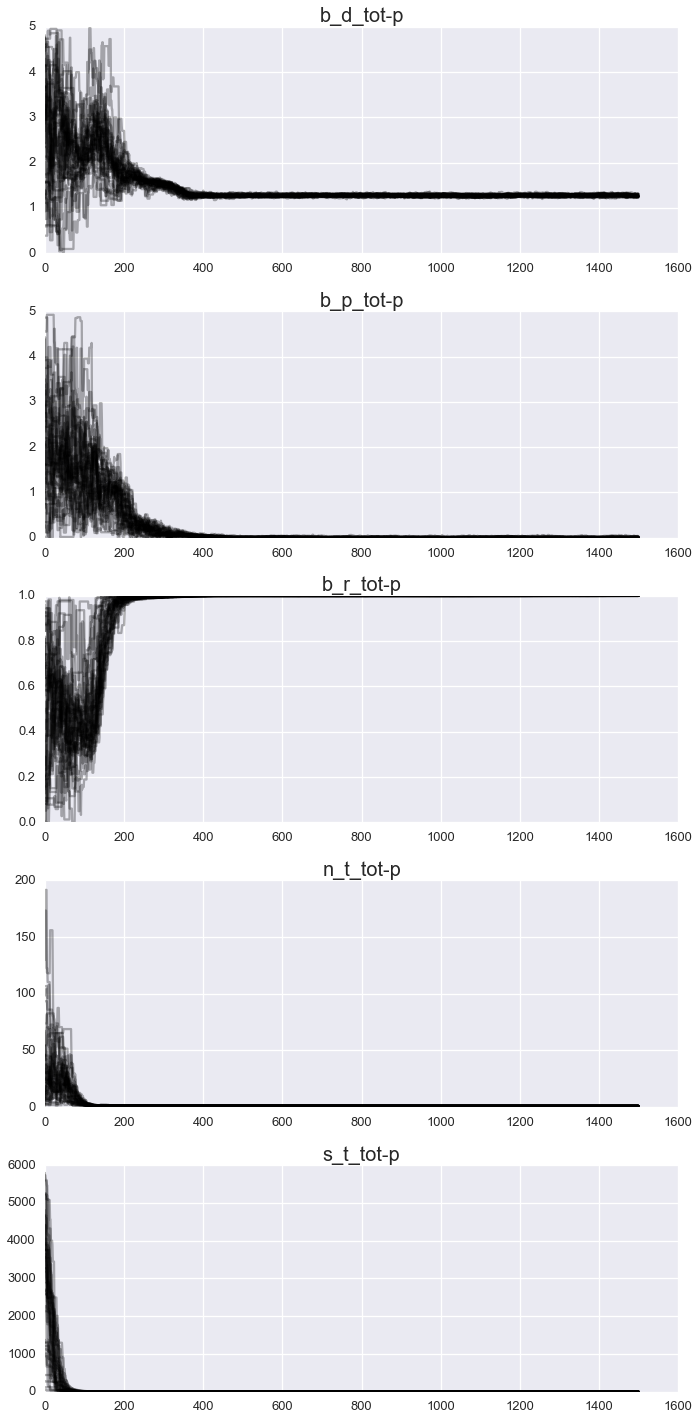

In [21]:
# emcee parameters
n_dim = 5        # Number of parameters being calibrated
n_walk = 40       # Number of "walkers"/chains
n_steps = 1500    # Number of steps per chain
n_burn = 1000     # Length of burn-in to discard

# Plot to save 
out_png = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\NOPE_RID_Calibration_Data\MCMC\tot-p_traces.png')

# Chains to save
out_txt = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\NOPE_RID_Calibration_Data\MCMC\tot-p_chains.txt')

# Run MCMC
samples = run_mcmc(n_dim, n_walk, n_steps, n_burn, par_dict, 
                   out_png, out_txt, log_vals=False)

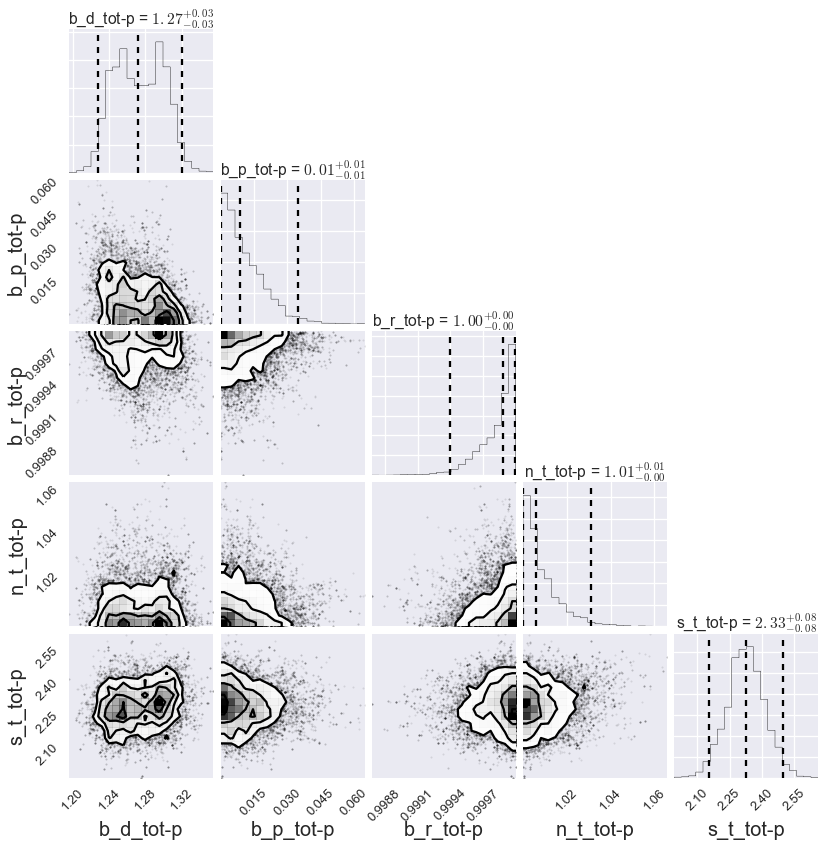

In [22]:
# Triangle plot
tri = corner.corner(samples,
                    labels=sorted(par_dict.keys()),
                    quantiles=[0.025, 0.5, 0.975],
                    show_titles=True, 
                    title_args={'fontsize': 24},
                    label_kwargs={'fontsize': 20})

# Save
out_png = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\NOPE_RID_Calibration_Data\MCMC\tot-p_corner.png')
plt.savefig(out_png, dpi=300)

And here are the same plots for N

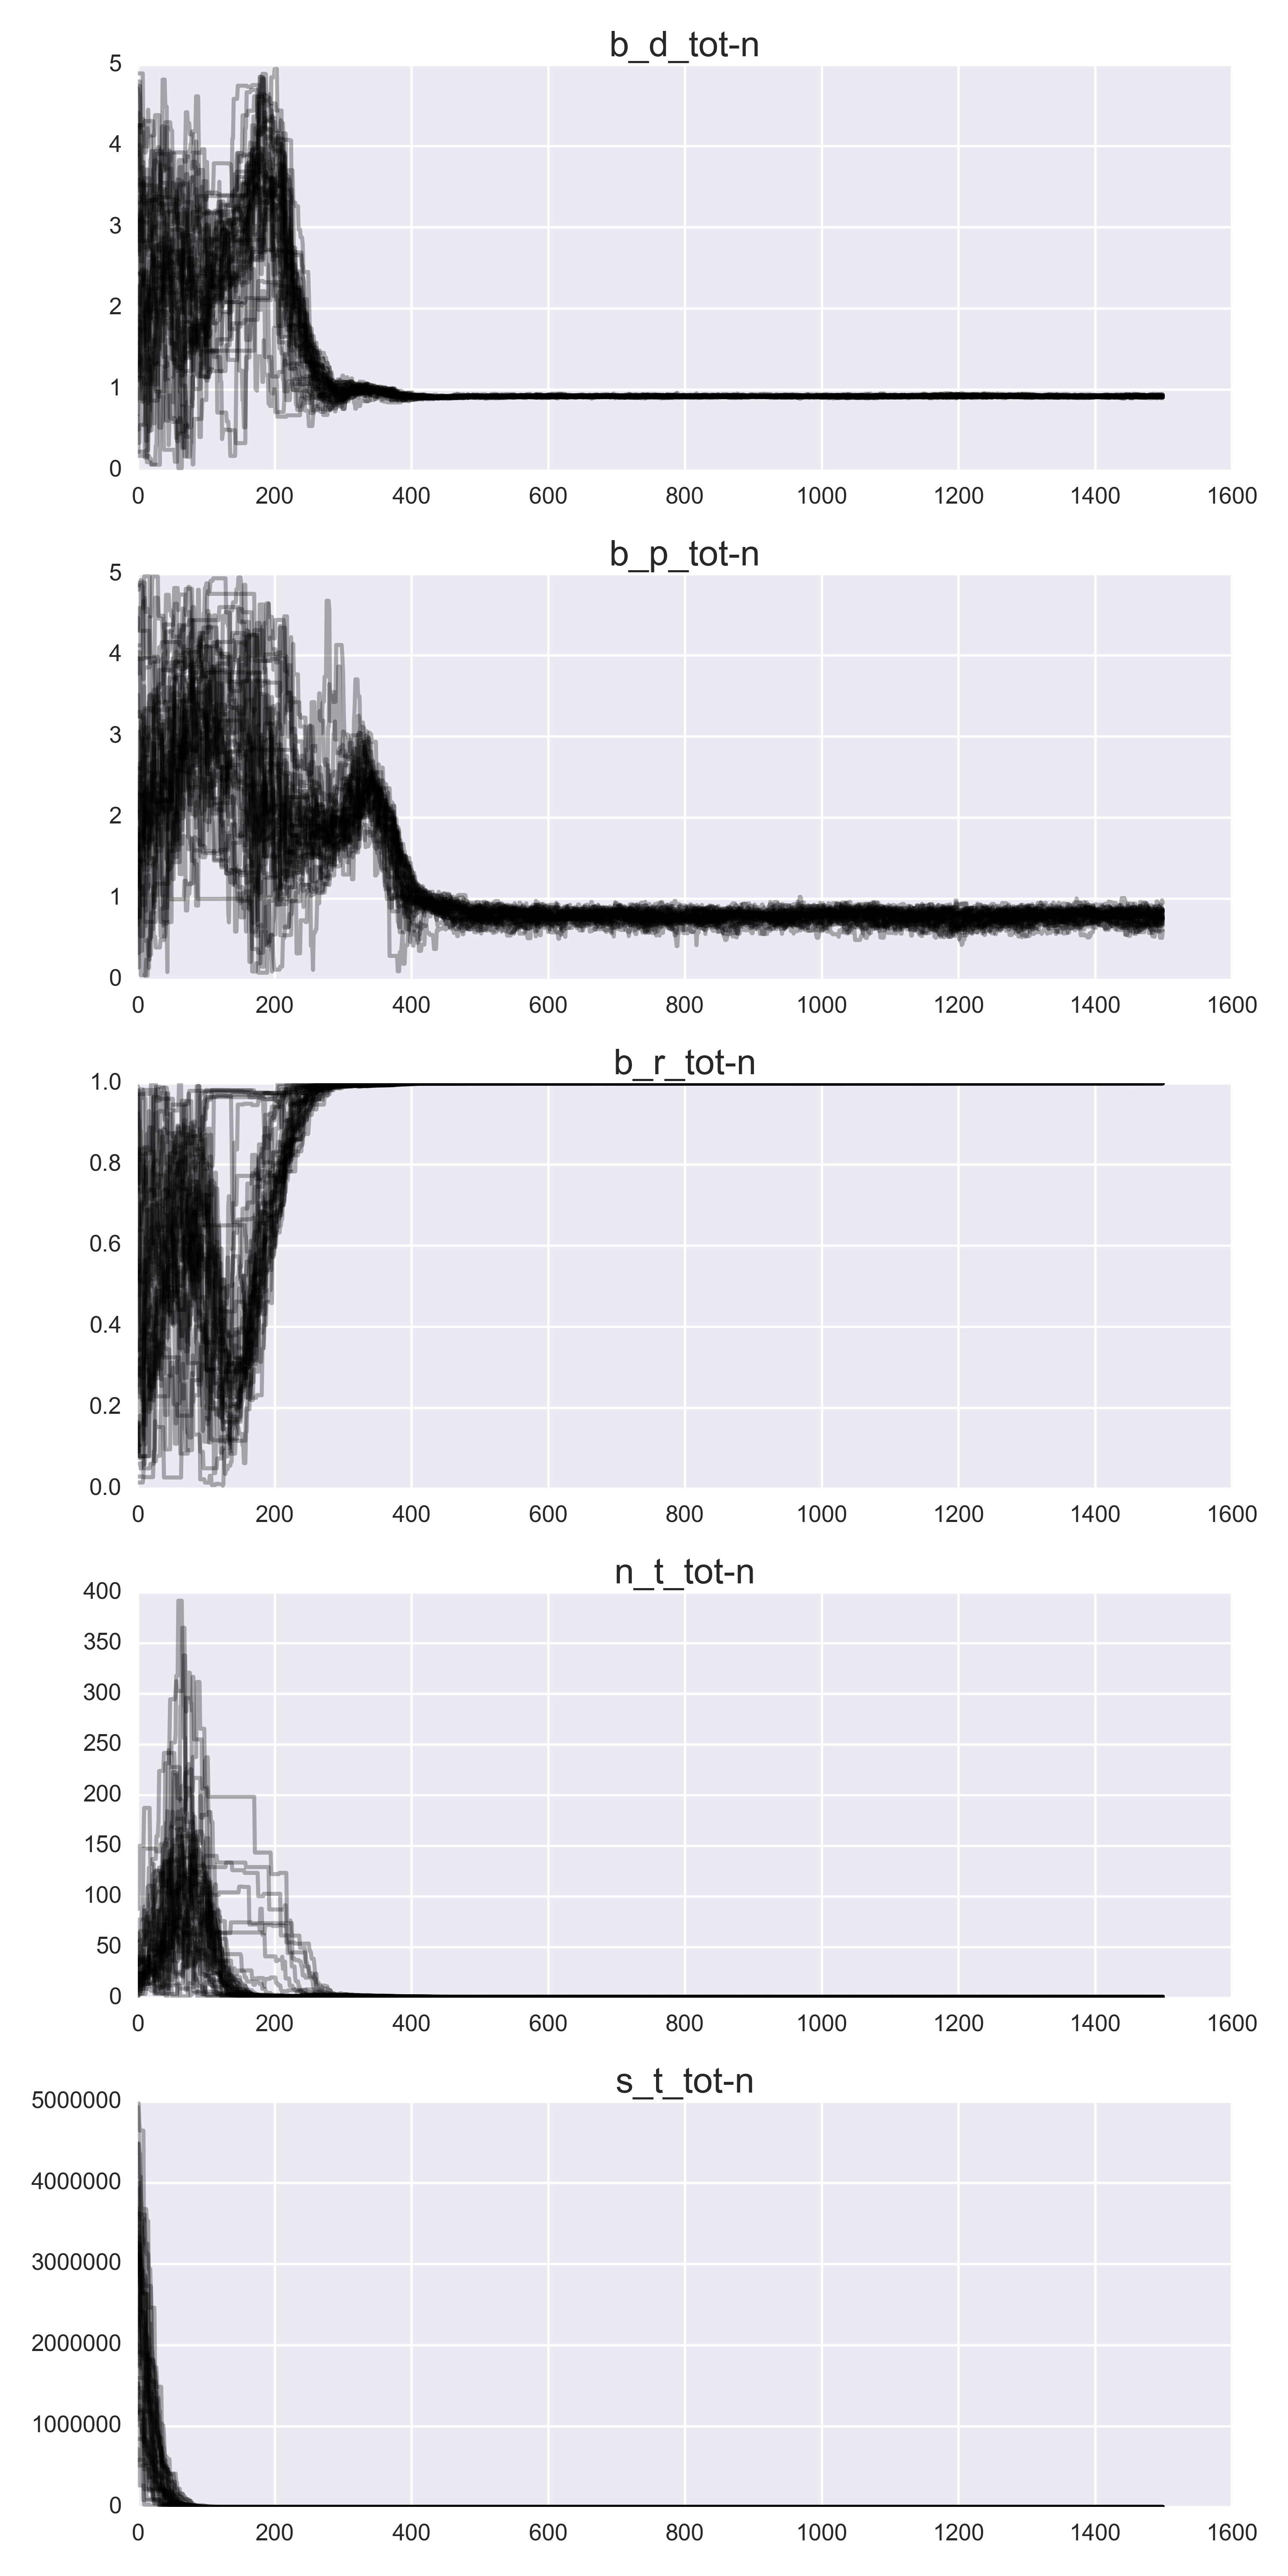

In [14]:
# Show chains
png_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\NOPE_RID_Calibration_Data\MCMC\tot-n_traces.png')
Image(png_path)

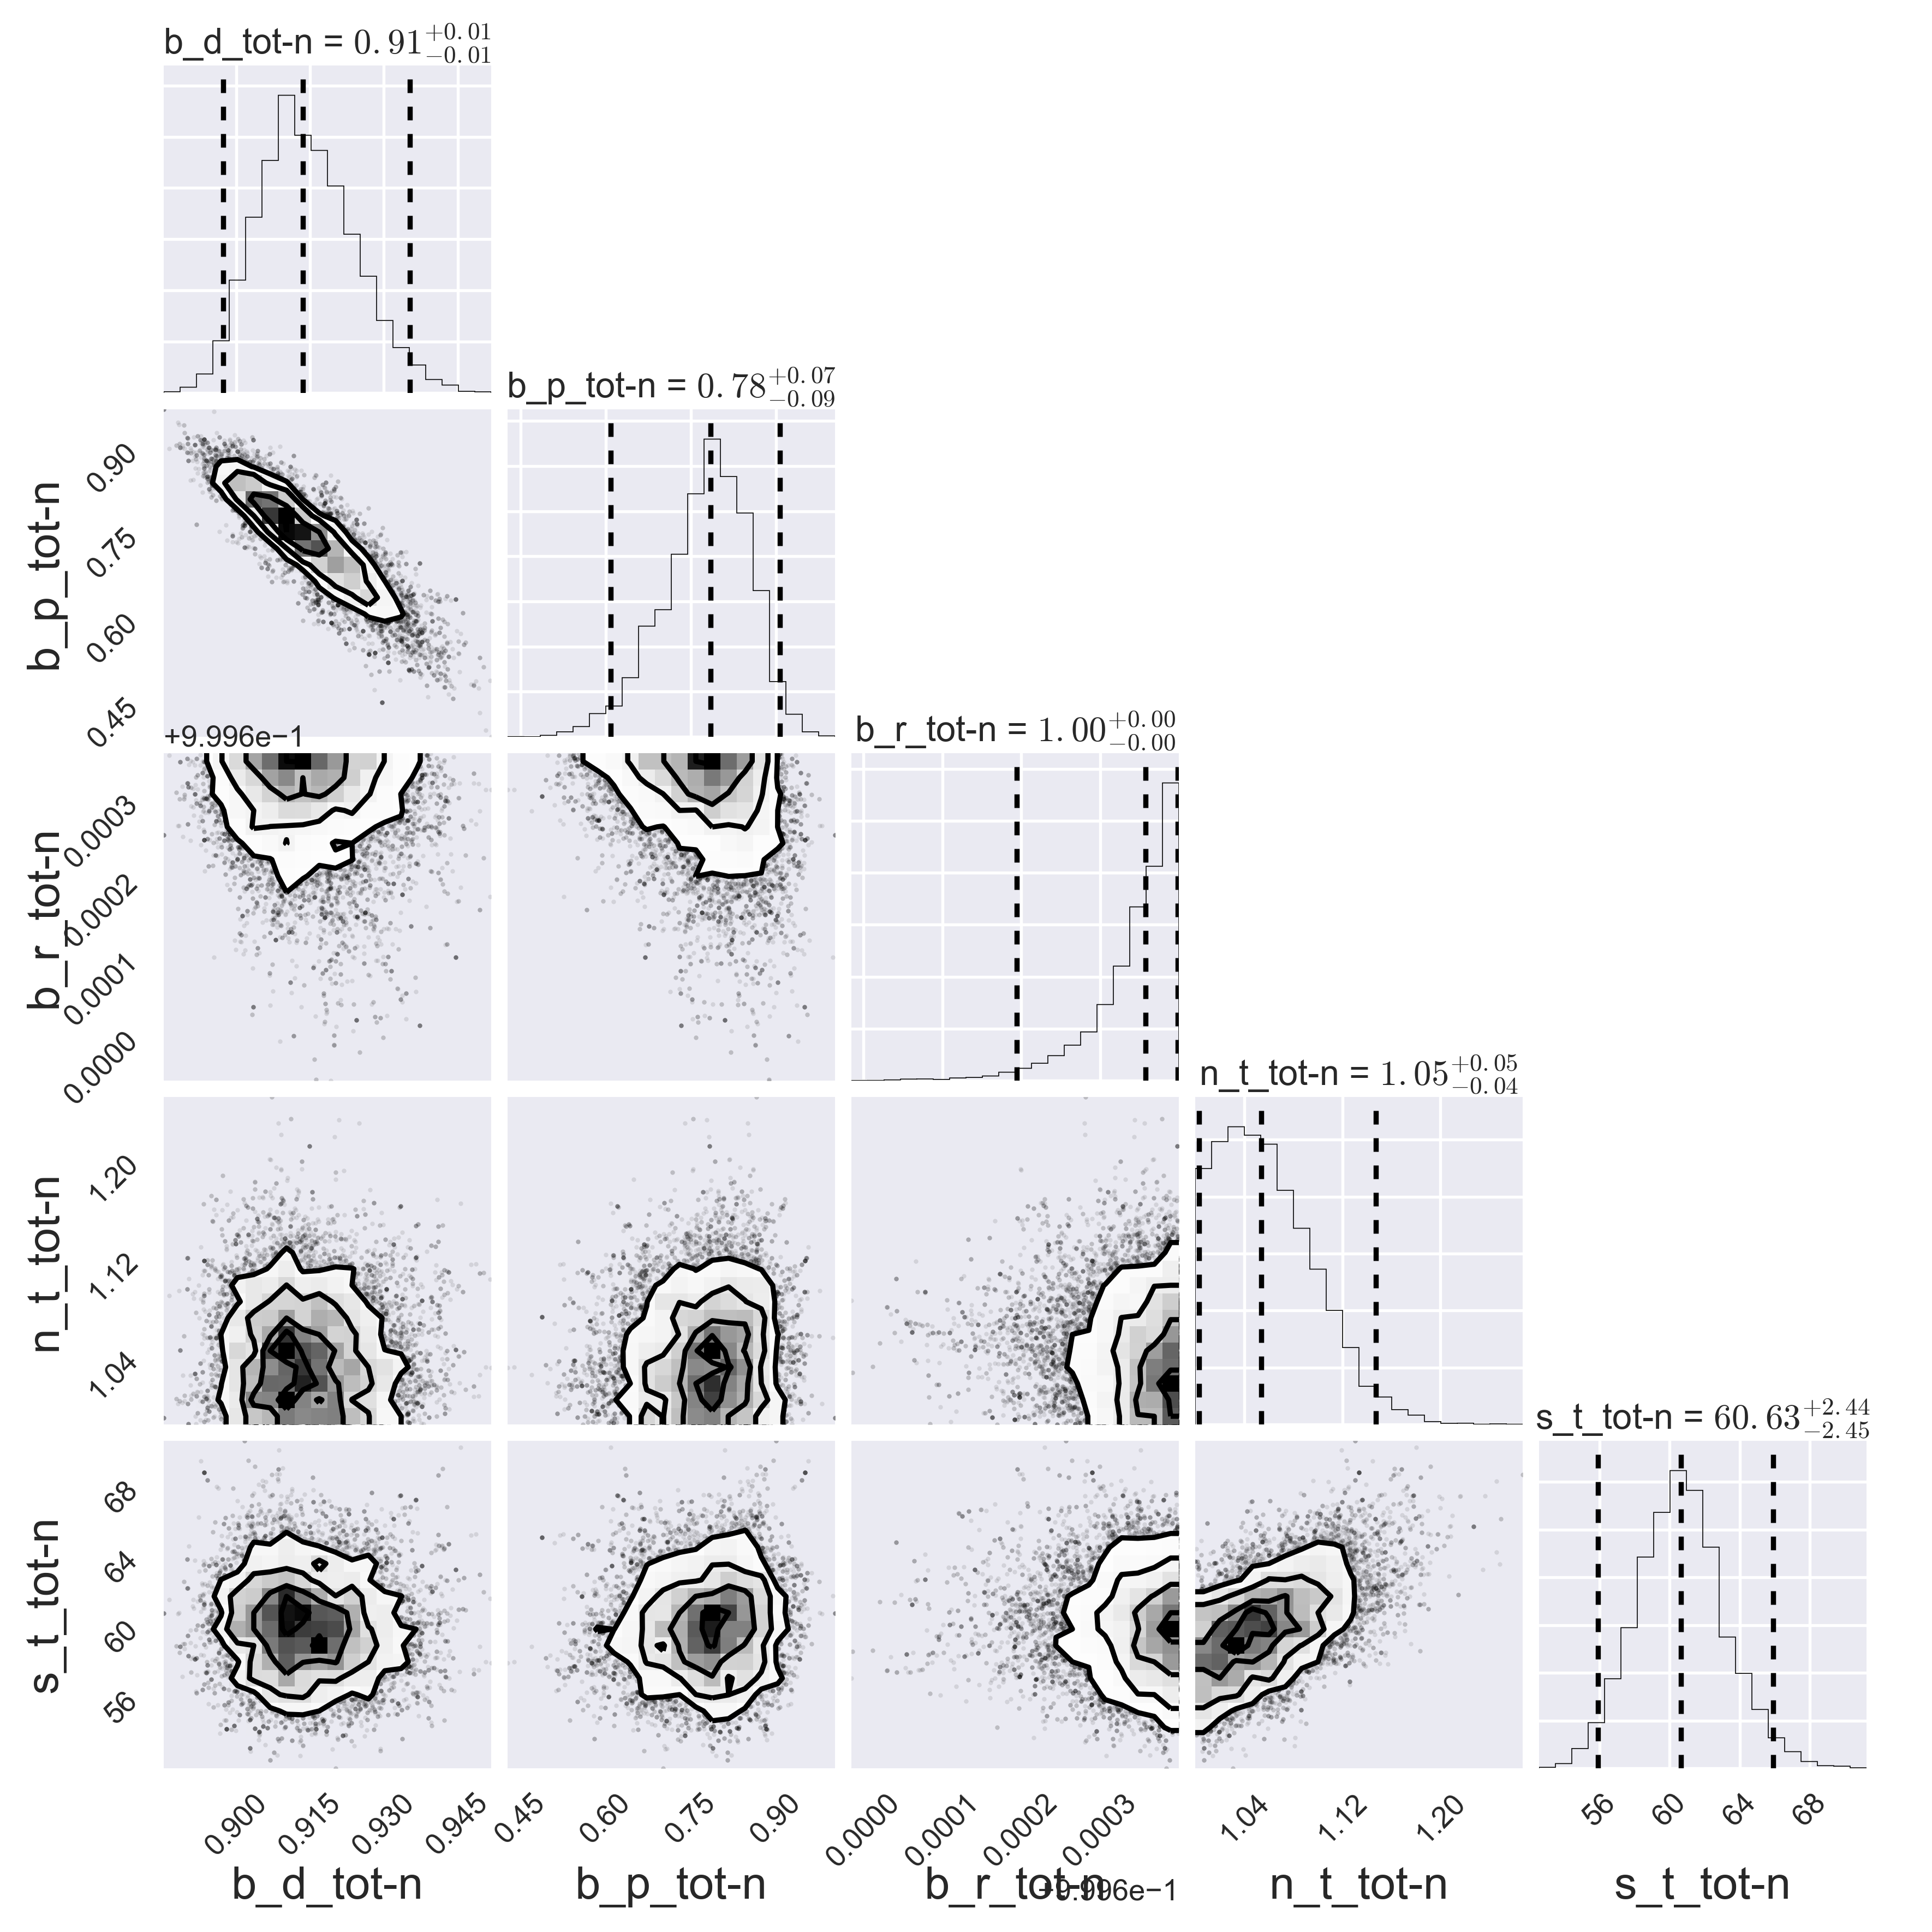

In [15]:
# Show corner plot
png_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
            r'\NOPE\NOPE_RID_Calibration_Data\MCMC\tot-n_corner.png')
Image(png_path)

## 6. Results

Overall, these results are pretty nice - especially for N. The posteriros are very clearly defined in all cases:

 * The transmission coefficients, $\beta_r^X$, are both very tightly constrained to be 1, which implies the retention factors estimated by TEOTIL are fairly reasonable. <br><br>
 
 * The degrees-of-freedom parameters, $\nu^X$, are also very well constrained to 1, which implies a t-distribution with heavy tails (i.e. robust to outliers) gives a better fit to the data. <br><br>
 
 * The error standard deviations $\sigma^N$ and $\sigma^P$ are around 60.6 and 2.3, respectively, which seems reasonable. <br><br>
 
 * For N, $\beta_d^N$ and $\beta_p^N$ are well constrained and, unsurprisingly, there are clear interactions between the two (as illustared by the obvious probability "ridge" on the upper-left contour plot). These results imply that the diffuse N inputs calculated based on land use etc. are roughly correct, but slightly too large: applying a "global" correction factor of 0.91 leads to better results. The point N inputs seem to be similarly overestimated, and a correction factor of 0.78 is appropriate. <br><br>
 
 * For P, the results are a bit more puzzling. It seems as though the best fit to the observed data can be achieved by setting the point input coefficent, $\beta_p^P$, to zero, and then increasing the diffuse coefficient, $\beta_d^P$, to around 1.27. In other words, the model works better if we forget about the point input datasets for P and instead diffuse inputs from the land. This seems unrealistic, and is likely an indicator that either (i) the point input data for P have serious quality issues, or (ii) the model is failing to adequately represent P processes and retention. This is not surprising because P is notoriously difficult to simulate, but it looks as though **we probably need to revise the model structure for P in order to obtain sensible results**. 
 
As a quick sense check, it's a good idea to plot modelled versus observed values for the most likely parameter set (the MAP estimate), which can be read off the plots above.

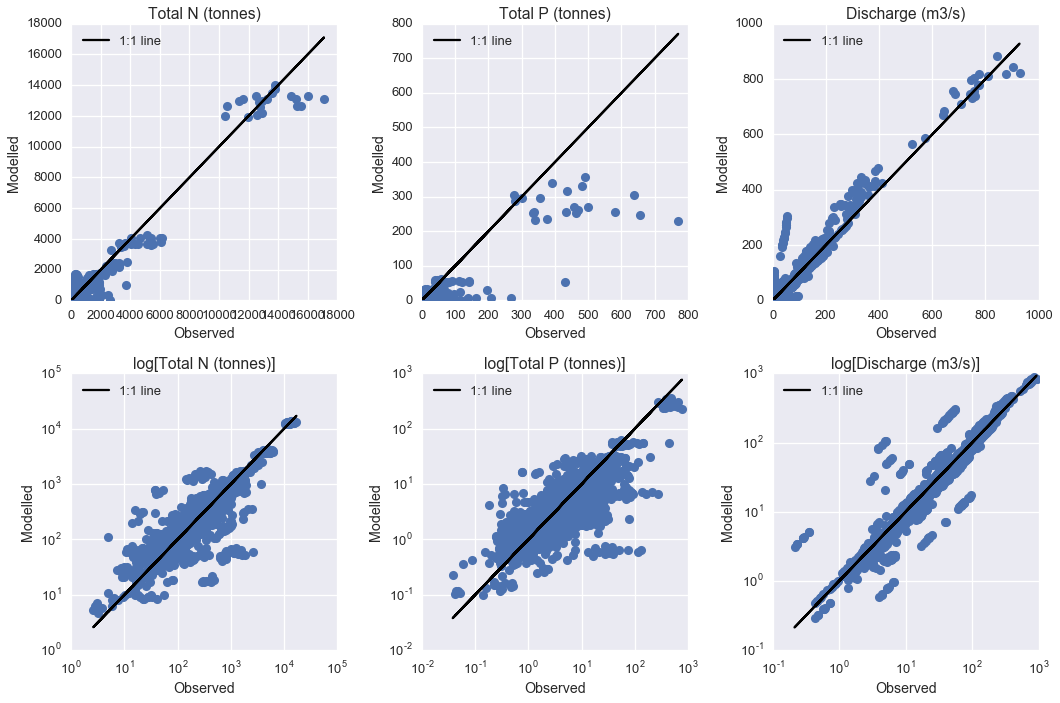

In [16]:
# MAP params from corner plots
cal_pars = {'b_r_tot-n':1,
            'b_r_tot-p':1,
            'b_p_tot-n':0.78,
            'b_p_tot-p':0.01,
            'b_d_tot-n':0.91,
            'b_d_tot-p':1.27,
            's_t_tot-n':60.63, 
            's_t_tot-p':2.33,
            'n_t_tot-n':1.05, 
            'n_t_tot-p':1.01}

# Run model with default params
df = nope.run_model_multi_year(g, nd_list, st_yr, end_yr, in_data, 
                               par_list, calib_nds, cal_pars=cal_pars)

# Join results
df = pd.merge(obs_df, df, how='left',
              left_on=['nve_vassdrag_nr', 'year'],
              right_on=['regine', 'year'])

# Convert obs flow to m3/s
df['obs_q_m3/s'] = df['mean_q_1000m3/day']*1000/(24*60*60)
del df['mean_q_1000m3/day']

# Drop 2016 obs data as can't model this yet
df = df.query('year != 2016')

# Assert no NaN
assert ~pd.isnull(df).all().all()

# Plot
plot_mod_obs(df)